In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("../../../../FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 5  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 6  | Account from offset between diffuse focus        | <input type="checkbox">  |      Done by Zeren                       |
| 7  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 8  | Add CNES moves to google drive     | <input type="checkbox">  |                             |

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack
import matplotlib.patches as patches
import unittest
import pandas as pd
import datetime
# from mpl_interactions import heatmap_slicer
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2023:
Elg = 1.0063 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0272 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09258 ''/inc and Ce is 0.01027 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F4"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F4_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-2023-0-%s.pkl"%(Field)
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib
G2UV = Guider2UV(filename=previous_xy_mapping)

# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1.
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
    # raise ValueError("Please verify the initialization mapping")



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    (0.18585616, 0.01856568)>
FOV center pixel position in guider [array(1377.264363), array(605.11696717)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39242605  36.4130725262  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024526131524219  0.00024414585789761  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV cente

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )

# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([-12.92,0.58])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus
## 4 - Align siderostat frames
## 5 - Go to guider reference
## 6 - Set UV/guider best focus offset
## 7 - Rotate mask carousel
## 8 - Through focus in UV
## 9 - Note open-mask guider ref point


## 10 - Go through the list of slits


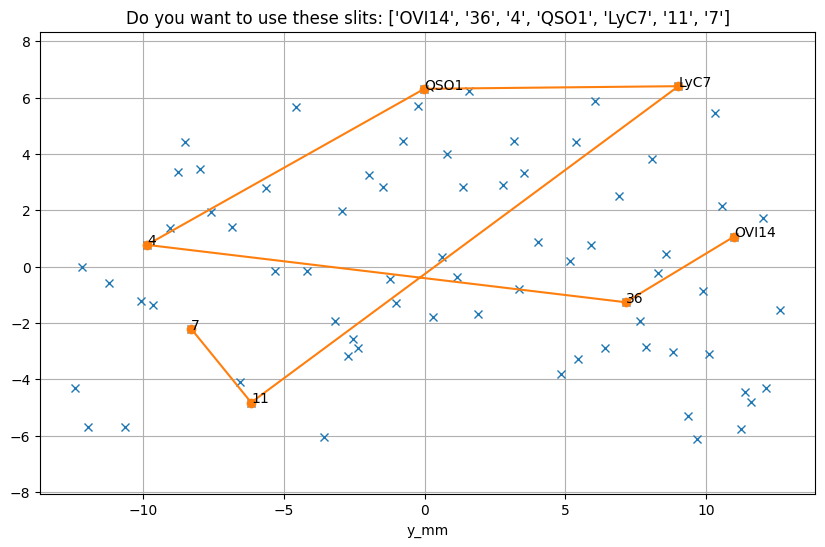

In [7]:
# slits = ['46', '35', '12', '38"] #F1
# slits =['3', '22','11', '20', '16', '18', '10', '5',"0"] #F2
# slits = ['4', '13', '22', '12', , '6', '23', "5", "20", "10"] # F3 with 206
slits = ['OVI14', '36', '4', 'QSO1', 'LyC7', '11',"7"] #F4
# slits = ['17', '6', '14', '1', '16', '7',"10","0","16"] #QSO
F1['Internal-count'] = F1['Internal-count'].astype(str)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.axis('equal')
plt.grid()
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
star_target_path = "Calibration/Targets/2022/GuidingStars/%s_guidingstars.csv"%(Field)
F1_stars = Table.read(star_target_path).to_pandas()

stars =  [29, 34, 18, 14 ]
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [10.983847  1.063581]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-9.854999  0.771802]
slit position in mm on mask: [-0.007602  6.3115  ]
slit position in mm on mask: [9.013465 6.404684]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-8.28209  -2.212253]

targets local coords in siderostat local frame:
EL: 378.0 arcsec ; CE: 424.2 arcsec
EL: 279.3 arcsec ; CE: 264.2 arcsec
EL: 365.6 arcsec ; CE: -442.5 arcsec
EL: 600.4 arcsec ; CE: -33.0 arcsec
EL: 604.4 arcsec ; CE: 342.3 arcsec
EL: 128.4 arcsec ; CE: -288.7 arcsec
EL: 239.1 arcsec ; CE: -377.1 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=239.1447 and CE=-377.1191


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
slits_coord_obs_det = np.array([
[    577.3+1072,	295.3      ],
[    411.3+1072,	587.5       ],
[    537.5+1072,	1892.9      ],
[    913.8+1072,	1148.6      ],
[    933.6+1072,	455.9       ],
[    161.4+1072,	1600.5     ],
[    336.5+1072,	1770.2      ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.20599872, -0.20192469)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.14933013, -0.1133101)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.19209121, 0.28376701)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.32553946, 0.05946237)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.3306684, -0.15203436)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: -63.5 arcmin
dx: 30.3 arcsec
dy: -115.7 arcsec
variances: [1.94288444 0.4210829  0.58553789]

residuals in arcsec: [[ -3.48660485   7.13654905]
 [  3.70729569 -14.00229716]
 [ -3.27403333   8.62432909]
 [ -6.94706533  15.54214174]
 [  4.35213076  -9.63020849]
 [  5.64827706  -7.67051424]]
max residual in EL,CE 6.9, 15.5 arcsec
mean residual in EL,CE 4.8, 10.9 arcsec
After updating:
    mask_rotation: -63.52248774603159 arcmin
    FOV center in guider: 1410.8640183516272 x 462.2277293282828 pix = 700.5766404700232 arcsec x -61.18522713256706 arcsec arcsec
    mask_magnification correction: 1.0  
    
[-0.06379442 -0.075749    0.06651622  0.02603427  0.21023703  0.15651083
  0.20467865  0.33364616  0.33615065  0.07259688  0.13374263] [-0.06366929 -0.10016956  0.0459035   0.0560103  -0.23951431 -0.14891941
  0.25014379  0.01874566 -0.19320853  0.16315528  0.21312   ]
[-0.0565655  -0.06919452  0.07576983  0.03547463  0.2142167   0.1621645
  0.2177061

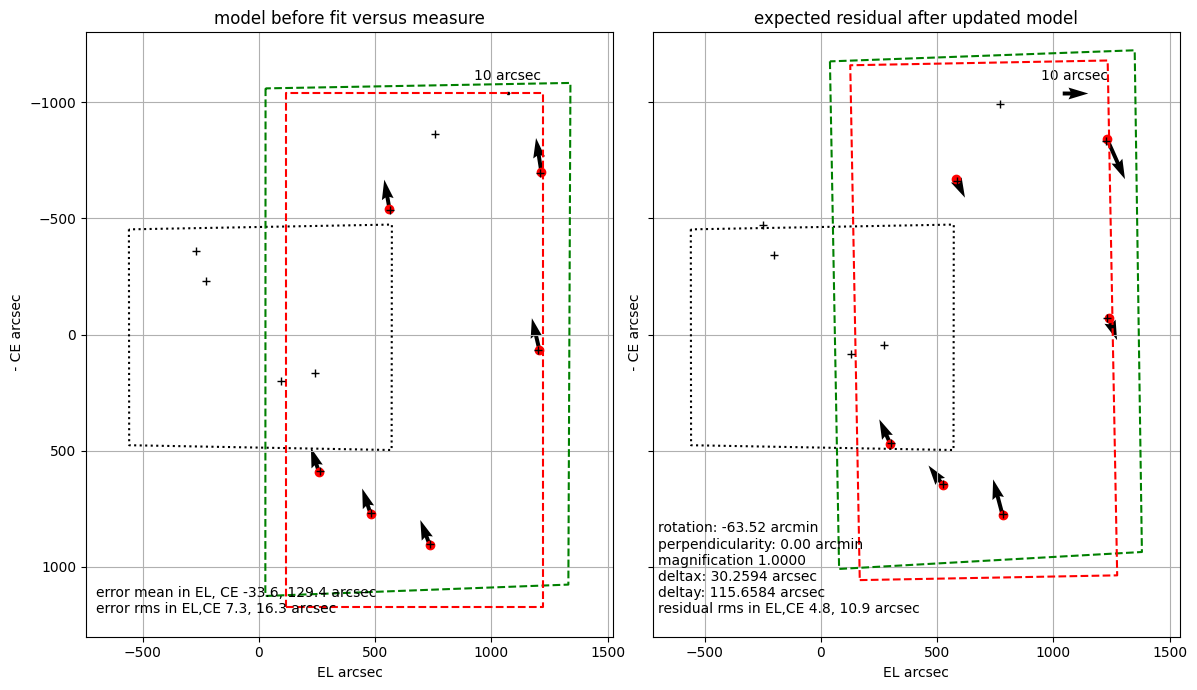


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [10]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),gamma=False,selected_stars=stars_and_slits)


### check updating without fitting magnification

In [11]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False)



Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39242605  36.4130725262  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024526131524219  0.00024414585789761  
NAXIS : 0  0

    mask_rotation: -63.52248774603159 arcmin
    FOV center in guider: 1410.8640183516272x462.2277293282828 pix

Fitting rotation, translation and magnification
gamma: 1.0140512561059865
theta: -60.723613365535705 arcmin
dx: 20.37031185465773 arcsec
dy: -118.46105893383984 arcsec
variances: [4.95165184e-04 1.70225251e+00 5.284

SystemExit: 

/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### save corrected model for future use (eg redo the calib on same field)

## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

slit position in mm on mask: [10.983847  1.063581]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-9.854999  0.771802]
slit position in mm on mask: [-0.007602  6.3115  ]
slit position in mm on mask: [9.013465 6.404684]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-8.28209  -2.212253]

targets local coords in siderostat local frame:
EL: 384.5 arcsec ; CE: 486.0 arcsec
EL: 289.0 arcsec ; CE: 324.7 arcsec
EL: 388.5 arcsec ; CE: -378.3 arcsec
EL: 615.2 arcsec ; CE: 34.3 arcsec
EL: 612.1 arcsec ; CE: 408.4 arcsec
EL: 148.7 arcsec ; CE: -229.2 arcsec
EL: 260.9 arcsec ; CE: -315.3 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


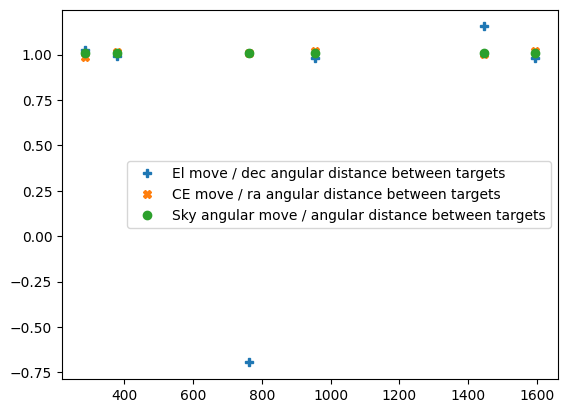

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
OVI14,10.983847,1.063581,37.162998,0.676824,326.14804293402585,193.39919999999978,379.17779005413155,-95.54324932107276,-161.3101322841922,-192.29034358359104,-331.3955357646444,383.1430246790762,1.0104574548640588,-0.9942664891250391,-1.0160892973123865
36,7.136533,-1.264856,37.072395,0.623102,1436.6354406838698,-173.39399999999964,1447.0614598782377,99.49136905036363,-702.9813708198108,200.23632935076185,-1444.204928212219,1458.02004864965,1.0075729947035799,-1.1548054105145638,-1.0052688993421643
4,-9.854999,0.771802,36.673306,0.671267,-833.0332254840134,-464.3028,953.6883373765977,226.7687837436623,412.5596997062389,456.39485416249477,847.5626470764971,962.6311358071292,1.0093770659449726,-0.9829681280459536,-1.0174415871396267
QSO1,-0.007602,6.3115,36.90472,0.80024,-763.035570459838,-8.996400000000104,763.0886036365177,-3.111207971190666,374.12353151659937,-6.261617162818334,768.5993831477017,768.624888762081,1.0072551013069517,0.6960136457714488,-1.0072916819389044
LyC7,9.013465,6.404684,37.116695,0.802739,1282.8816797461332,948.7799999999999,1595.6092543690827,-463.45382804637705,-637.5815128822303,-932.7471743261384,-1309.8474600652537,1608.0166851910437,1.007775983241503,-0.9831016403445884,-1.0210196939786815
11,-6.155668,-4.825373,36.760304,0.539189,179.8804346155643,-220.11839999999992,284.26938065160004,112.26457521560043,-86.16847140615182,225.9436840789174,-177.02450765679828,287.03349053078364,1.0097235582420017,-1.0264643213784832,-0.9841231929149513


In [11]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:6]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 16 - Second interation on open mask


wave:  0.20619
Fitting rotation and translation
theta: 4.5 arcmin
dx: -6.7 arcsec
dy: -3.8 arcsec
variances: [1.94255284 0.40935227 0.59925556]

residuals in arcsec: [[ -4.76561038 -10.7253328 ]
 [  1.91302083   6.02936324]
 [  7.68511212  10.04764733]
 [  3.27120146 -14.47158675]
 [ -6.30804546   2.79637034]
 [ -1.79567857   6.32353864]]
max residual in EL,CE 7.7, 14.5 arcsec
mean residual in EL,CE 4.8, 9.2 arcsec
After updating:
    mask_rotation: -59.0188671187079 arcmin
    FOV center in guider: 1403.782726937349 x 459.20938999872305 pix = 693.9484823198055 arcsec x -64.04262740897077 arcsec arcsec
    mask_magnification correction: 1.0  
    


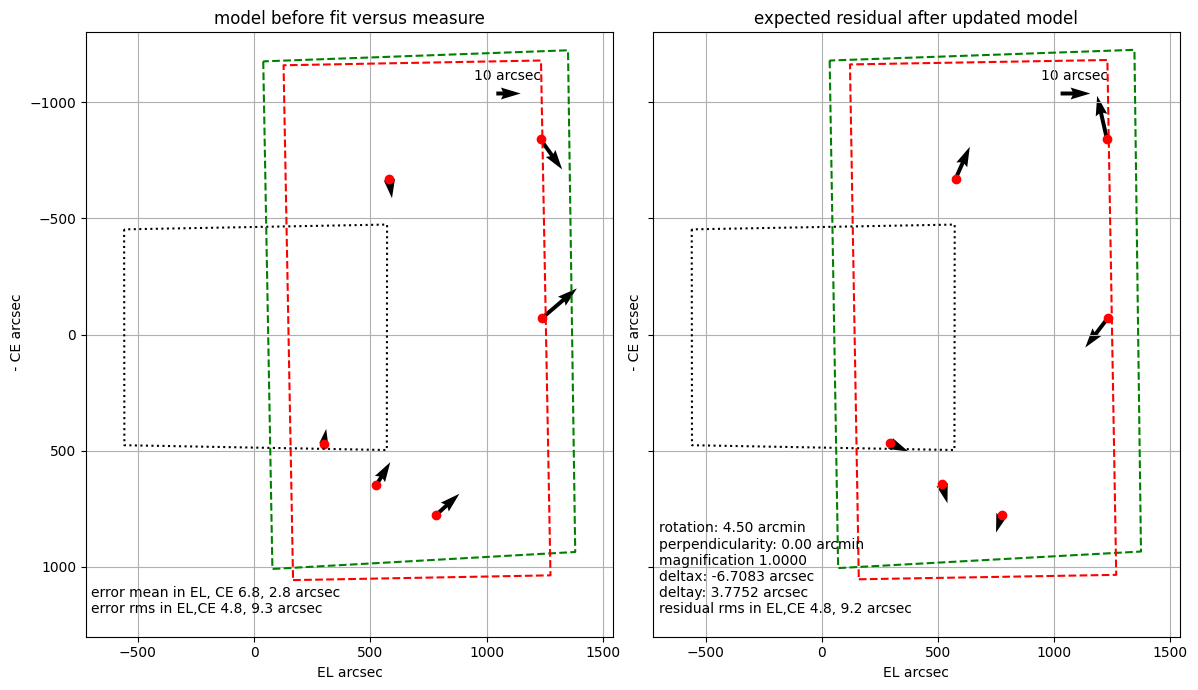


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            
slit position in mm on mask: [10.983847  1.063581]
slit position in mm on mask: [ 7.136533 -1.264856

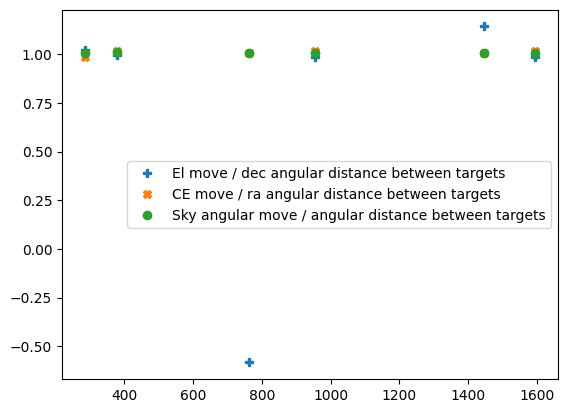

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
OVI14,10.983847,1.063581,37.162998,0.676824,326.14804293402585,193.39919999999978,379.17779005413155,-95.75657705435341,-161.18365089129276,-192.71968697959167,-331.1356923910718,383.13408165396396,1.010433869555671,-0.9964864745024379,-1.0152925935479395
36,7.136533,-1.264856,37.072395,0.623102,1436.6354406838698,-173.39399999999964,1447.0614598782377,98.54921434021377,-703.0920026903317,198.3401487811142,-1444.4322103270172,1457.9860166849019,1.007549476722007,-1.143869734714665,-1.0054271037887217
4,-9.854999,0.771802,36.673306,0.671267,-833.0332254840134,-464.3028,953.6883373765977,227.3148069901987,412.25878165722906,457.49378054847386,846.9444410366114,962.6086668233115,1.0093535058541785,-0.985334959316364,-1.016699472634498
QSO1,-0.007602,6.3115,36.90472,0.80024,-763.035570459838,-8.996400000000104,763.0886036365177,-2.6110034714063812,374.1184697339031,-5.254905586552483,768.5889842213305,768.6069481204943,1.007231590745398,0.5841120433231539,-1.0072780535750723
LyC7,9.013465,6.404684,37.116695,0.802739,1282.8816797461332,948.7799999999999,1595.6092543690827,-464.2949334925983,-636.9714928337169,-934.4399831472033,-1308.5942348775877,1607.9791521220056,1.0077524605219303,-0.984885835649153,-1.0200428110693285
11,-6.155668,-4.825373,36.760304,0.539189,179.8804346155643,-220.11839999999992,284.26938065160004,112.14666833686425,-86.31041686459173,225.706384694773,-177.31612040661724,287.026790819322,1.0096999900636552,-1.025386268002916,-0.9857443405980898


In [12]:
slits_coord_obs_det = np.array([
[ 598.2+1072,154.6   ],
[ 432.4+1072,458.4    ],
[ 578.5+1072,1797.1    ],
[ 952.2+1072,1022.7    ],
[ 964.3+1072,309.8    ],
[ 190.3+1072,1504.5   ],
[ 370.8+1072,1672.7    ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),gamma=False)#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:6]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


wave:  0.20619
Fitting rotation and translation
theta: -1.0 arcmin
dx: -2.4 arcsec
dy: -0.6 arcsec
variances: [1.9416309  0.4107593  0.60824572]

residuals in arcsec: [[-3.13992694 -1.16337985]
 [ 1.78510248 -2.29291177]
 [ 2.22357413 10.40697042]
 [-1.19937589 -3.53627189]
 [-1.03734143 -1.99722614]
 [ 1.36796765 -1.41718077]]
max residual in EL,CE 3.1, 10.4 arcsec
mean residual in EL,CE 1.9, 4.7 arcsec
After updating:
    mask_rotation: -124.55947580067992 arcmin
    FOV center in guider: 1430.601105420416 x 313.394956900593 pix = 718.0399553429453 arcsec x -194.19525878806743 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.21222457  0.136147    0.21725244 -0.14023426  0.21525321  0.16478293
  0.22729283  0.34794404  0.34283103  0.09208475  0.15502619] [ 0.08112228 -0.12203844 -0.18892027 -0.18654402 -0.31266745 -0.22014166
  0.17719042 -0.05884272 -0.27088692  0.09494884  0.14271603]
[ 0.21157219  0.13543426  0.21652095 -0.14096882  0.21448543  0.16404174
  0.2266687

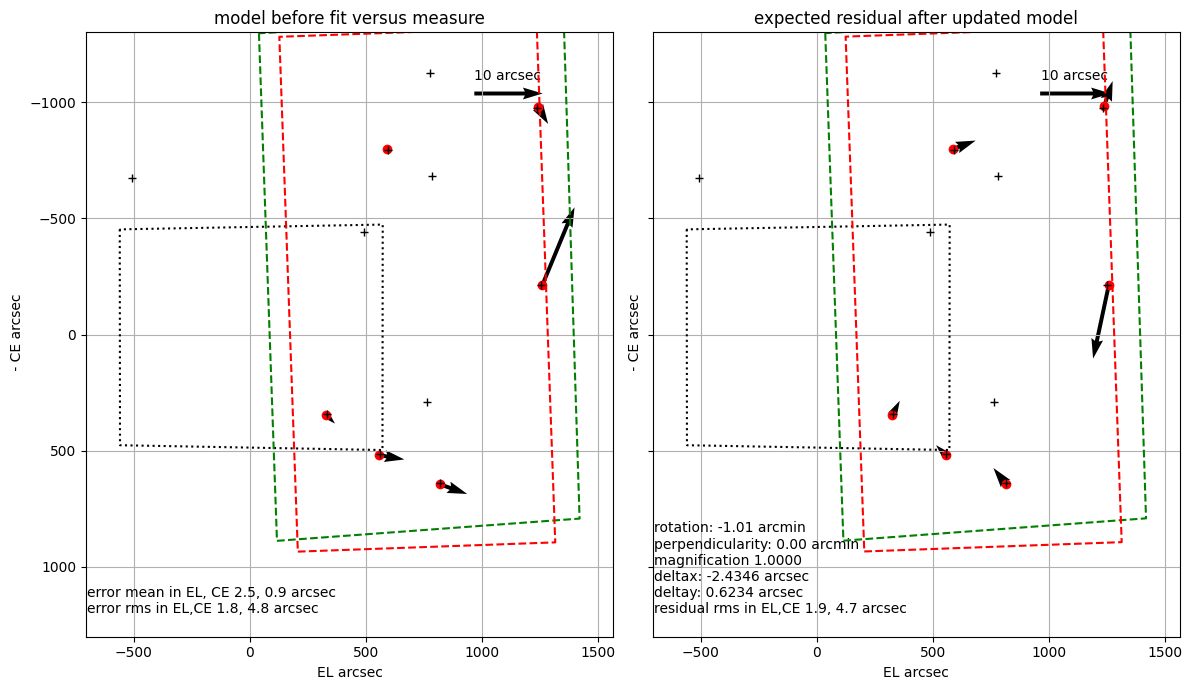


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            
slit position in mm on mask: [10.983847  1.063581]
slit position in mm on mask: [ 7.136533 -1.264856

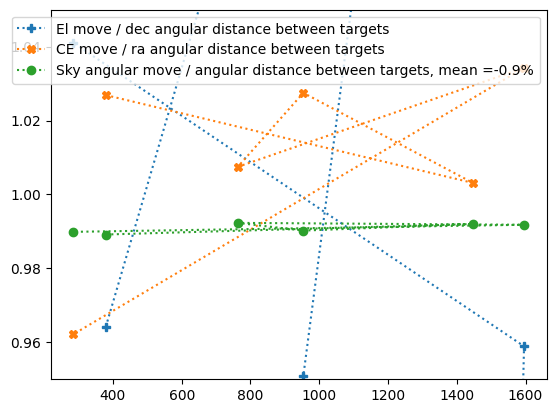

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
OVI14,10.983847,1.063581,37.162998,0.676824,326.14804293402585,193.39919999999978,379.17779005413155,-92.65204613469034,-163.02431824841483,-186.47150805067776,-334.9171594095434,383.3290061835283,1.0109479411460363,-0.9641793143439992,-1.0268869204200357
36,7.136533,-1.264856,37.072395,0.623102,1436.6354406838698,-173.39399999999964,1447.0614598782377,112.26027001865437,-701.4819913830804,225.93501943954377,-1441.1246030974003,1458.7277863473316,1.008062080839383,-1.3030152106736348,-1.003124774933433
4,-9.854999,0.771802,36.673306,0.671267,-833.0332254840134,-464.3028,953.6883373765977,219.36860128286693,416.63800311648,441.501246941898,855.9411136024963,963.0984067094765,1.009867027795227,-0.950890769863757,-1.027499369073992
QSO1,-0.007602,6.3115,36.90472,0.80024,-763.035570459838,-8.996400000000104,763.0886036365177,-9.890414881510189,374.19213320300537,-19.905448990527407,768.7403184522542,768.9979870673185,1.007744033134081,2.2126015951410762,-1.0074763853918085
LyC7,9.013465,6.404684,37.116695,0.802739,1282.8816797461332,948.7799999999999,1595.6092543690827,-452.0544346866829,-645.8490357255876,-909.804755250418,-1326.832258994647,1608.7972327751907,1.0082651679099985,-0.9589206720740511,-1.034259261740499
11,-6.155668,-4.825373,36.760304,0.539189,179.8804346155643,-220.11839999999992,284.26938065160004,113.86255189803231,-84.2447029611269,229.1597719499798,-173.0723177633391,287.172819494013,1.010213688283127,-1.0410750393878017,-0.9621519879759278


In [20]:
slits_coord_obs_det = np.array([
[ 595.8 + 1072 , 	164.9 ],
[ 431	 + 1072 , 465.1  ],
[ 574	 + 1072 , 1787.6   ],
[ 944.4 + 1072 , 	1022.2   ],
[ 958	 + 1072 , 318.2  ],
[ 190.6 + 1072 , 	1497.7  ],
[ 369.2 + 1072 , 	1663.6   ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),gamma=False,selected_stars=stars_and_slits)


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:6]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],":P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],":X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],1/new_cat["frame_divided_sky"],":o",label="Sky angular move / angular distance between targets, mean =%0.1f%%"%(100*(1/new_cat["frame_divided_sky"].mean()-1)))
plt.legend()
plt.ylim((0.95,1.05))
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


In [11]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/F4_XY_230615_seemsok.pkl")

Dumping to Calibration/Mappings/2023/XY/F4_XY_230615_seemsok.pkl



## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence
[36, 40, 46, 21 ]
we did not have the time to do this because G2UV was not well

In [ ]:
star_target_path = "Calibration/Targets/2022/GuidingStars/%s_guidingstars.fits"%(Field)
# il faut que le centre soit bien defini à l'arcseconde pres.
F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars =[29, 34, 18, 14 ]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()



# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: -104.4 arcsec ; CE: 169.0 arcsec
EL: -127.2 arcsec ; CE: 233.2 arcsec
EL: 134.3 arcsec ; CE: -20.8 arcsec
EL: 61.5 arcsec ; CE: -39.9 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [ ]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)
## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------